In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
import torch
import torch.nn.functional as F
from PIL import Image
import numpy as np


In [2]:
def generate_dct_filters(n):
    filters = np.zeros((n**2, n, n))

    for i in range(n):
        for j in range(n):
            filter = np.zeros((n, n))
            filter[i, j] = 1
            filters[i * n + j, ...] = idct(idct(filter, norm="ortho").T, norm="ortho")
            # filters.append(idct(idct(filter, norm="ortho").T, norm="ortho"))

    return filters


def check_orthogonality(filters):
    num_filters = len(filters)
    dot_products = np.zeros((num_filters, num_filters))

    for i in range(num_filters):
        for j in range(i, num_filters):
            dot_products[i, j] = np.sum(filters[i].reshape(-1) * filters[j].reshape(-1))
            dot_products[j, i] = dot_products[i, j]

    return dot_products

def dct_filters_and_plot(n, plot=True):
    filters = generate_dct_filters(n)

    if plot:
        # Plot each filter
        num_filters = n**2
        rows, cols = int(np.sqrt(num_filters)), int(np.sqrt(num_filters))

        fig, axes = plt.subplots(rows, cols, figsize=(12, 12))

        for i, ax in enumerate(axes.ravel()):
            ax.imshow(filters[i], cmap="gray", extent=[0, 1, 0, 1])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(f"Filter {i + 1}")

        plt.subplots_adjust(wspace=0.1, hspace=0.1)
        plt.savefig("dct_filters_and_plot.pdf", bbox_inches="tight")

        # Check orthogonality
        dot_products = check_orthogonality(filters)
        print("Dot Products (Orthogonality Check):")
        print(dot_products)

    return filters

Generate DCT filters and load them to `PyTorch`

In [3]:
n=3
dct_filters = dct_filters_and_plot(n=n, plot=False)
kernels = torch.FloatTensor(dct_filters).unsqueeze(1)

Load the Dali image and convert to `PyTorch` tensor

In [4]:
image_path = "/mnt/data_drive/hrodrigo/mri_rician_noise/deep-image-prior/dali-bw.jpg"  # subject_04_Std0.15.png
img = Image.open(image_path).convert("L")
img_tensor = torch.FloatTensor(np.array(img)[None, ...])  # CxHxW
img_tensor = img_tensor[None, ...] # add batch dimension

Apply convolutions and do away with batch dimension

In [5]:
result = F.conv2d(img_tensor, kernels, padding="same").numpy()[0]

Bonus: auxiliary function for plotting the list of convoluted kernels

In [27]:
def plot_kernels_and_img(img: np.ndarray, result: np.ndarray):
    _, axs = plt.subplots(3, 3, figsize=(24, 24))
    axs[0,0].imshow(img, cmap='gray')
    axs[0,0].set_title('Original image')
    axs[0,0].axis('off')
    for i in range(1, result.shape[0]):
        axs[i // n, i % n].imshow(
                result[i],
                cmap="gray",  # vmin=0.0, vmax=1.0
            )  
        axs[i // n, i % n].set_title(f"Convolution Result ({i}-th kernel)")
        axs[i // n, i % n].axis("off")

Now, we plot our images

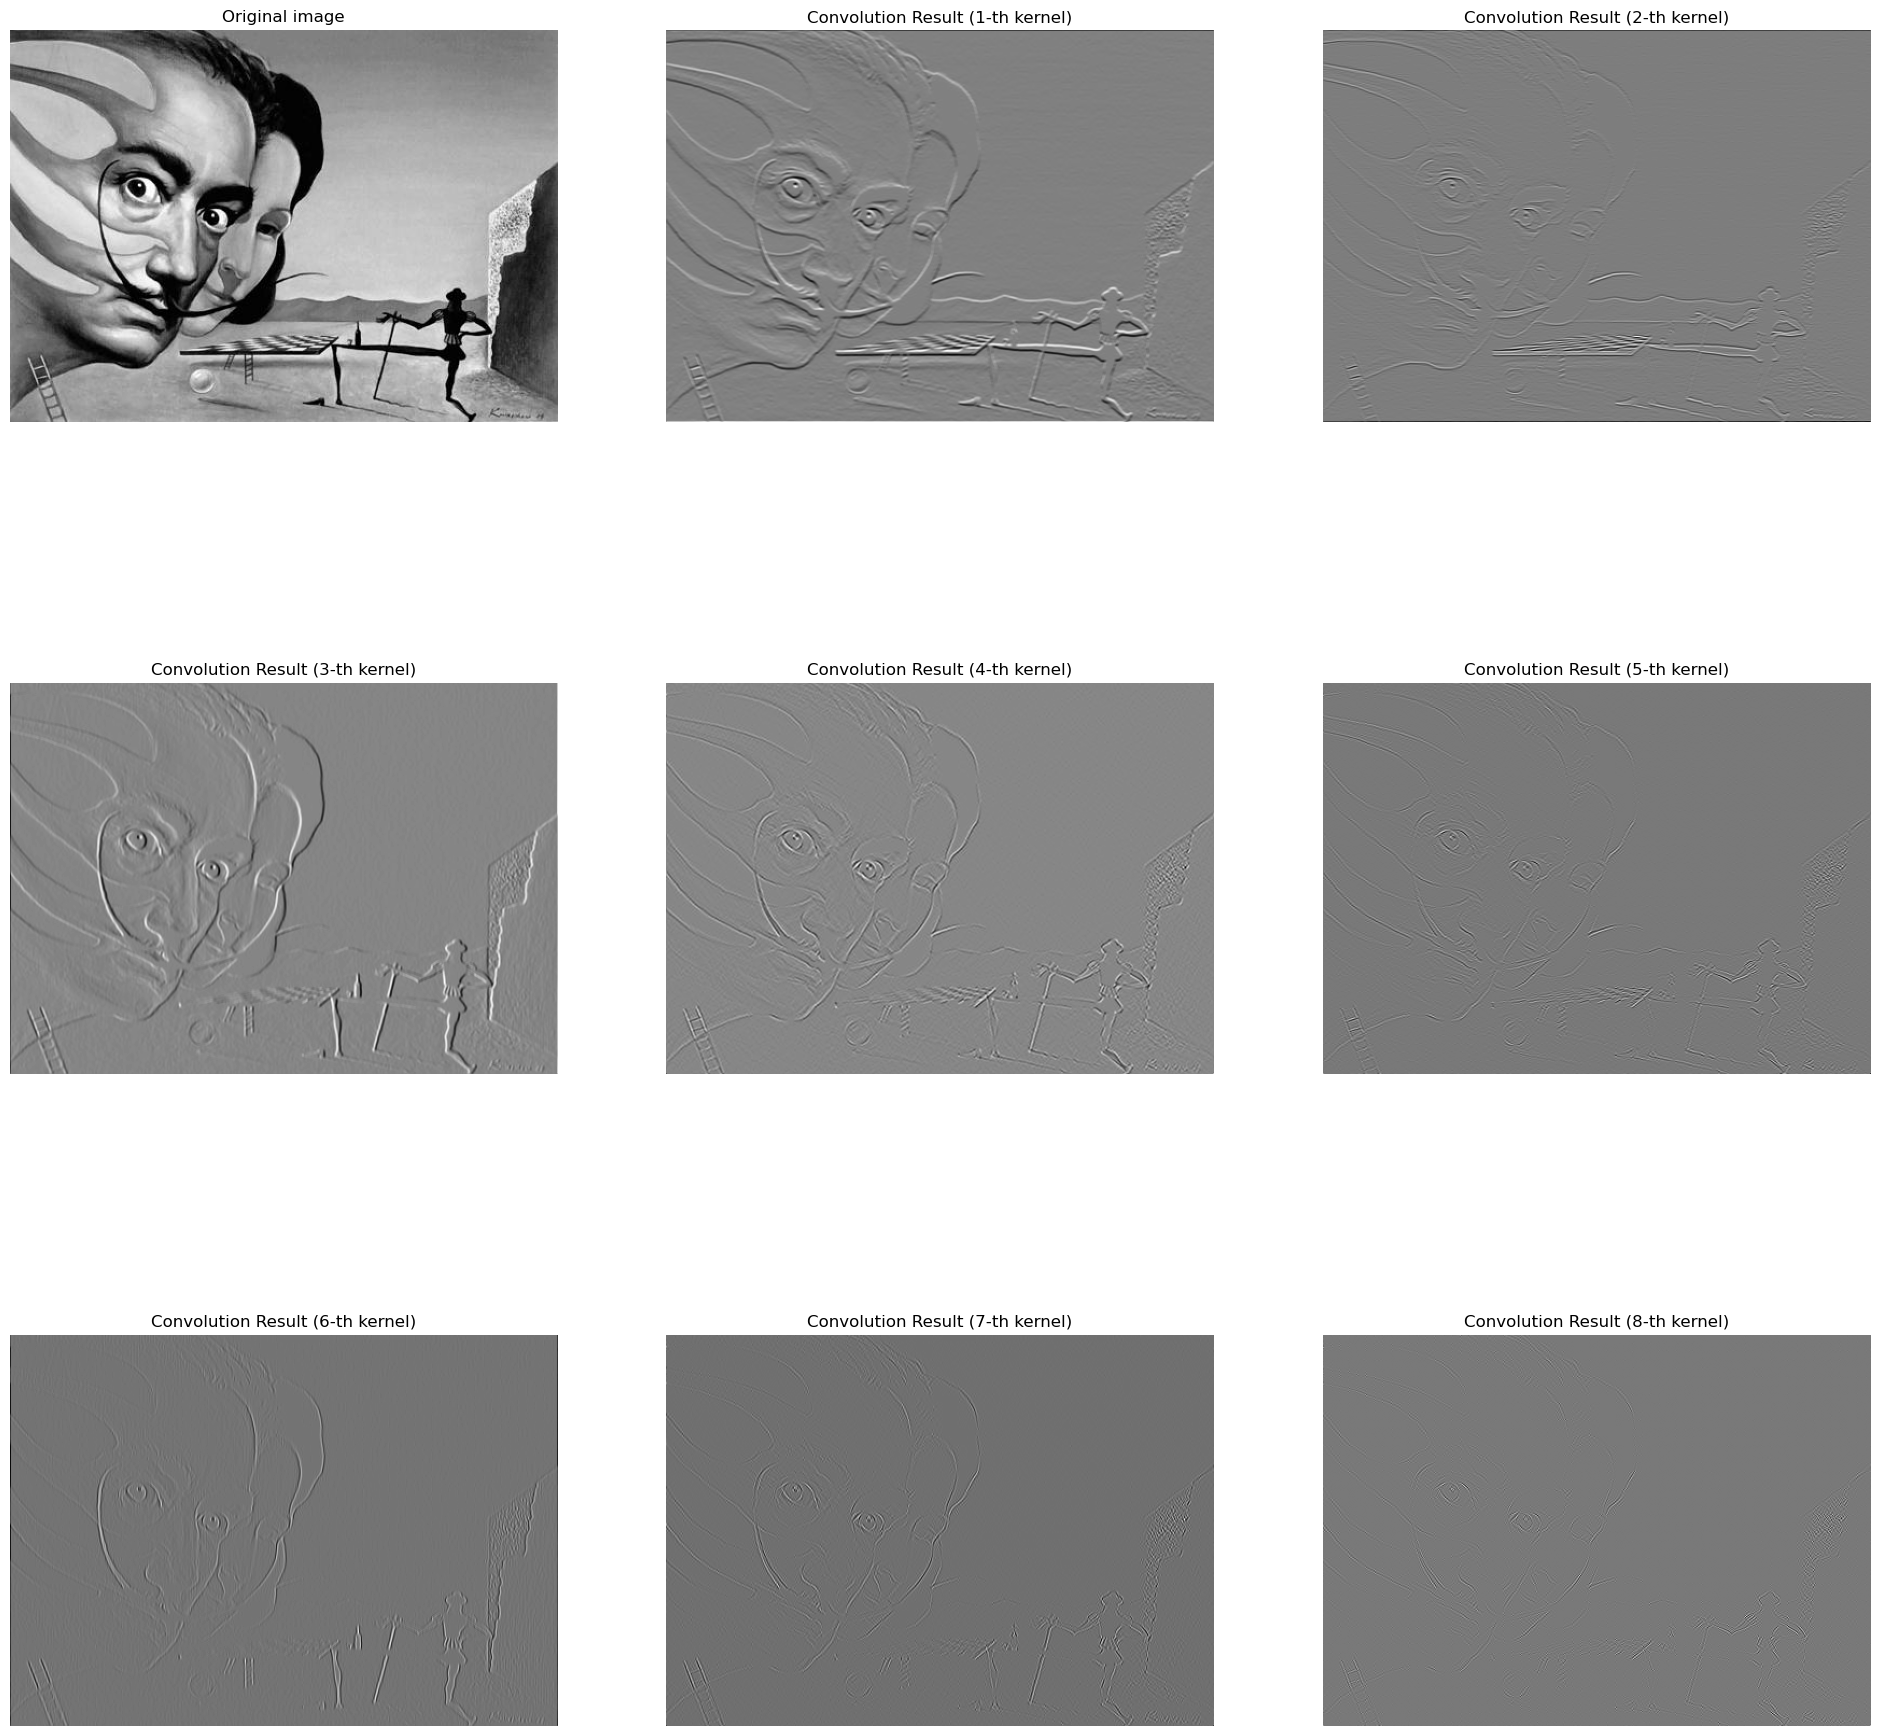

In [28]:
plot_kernels_and_img(np.array(img), result)

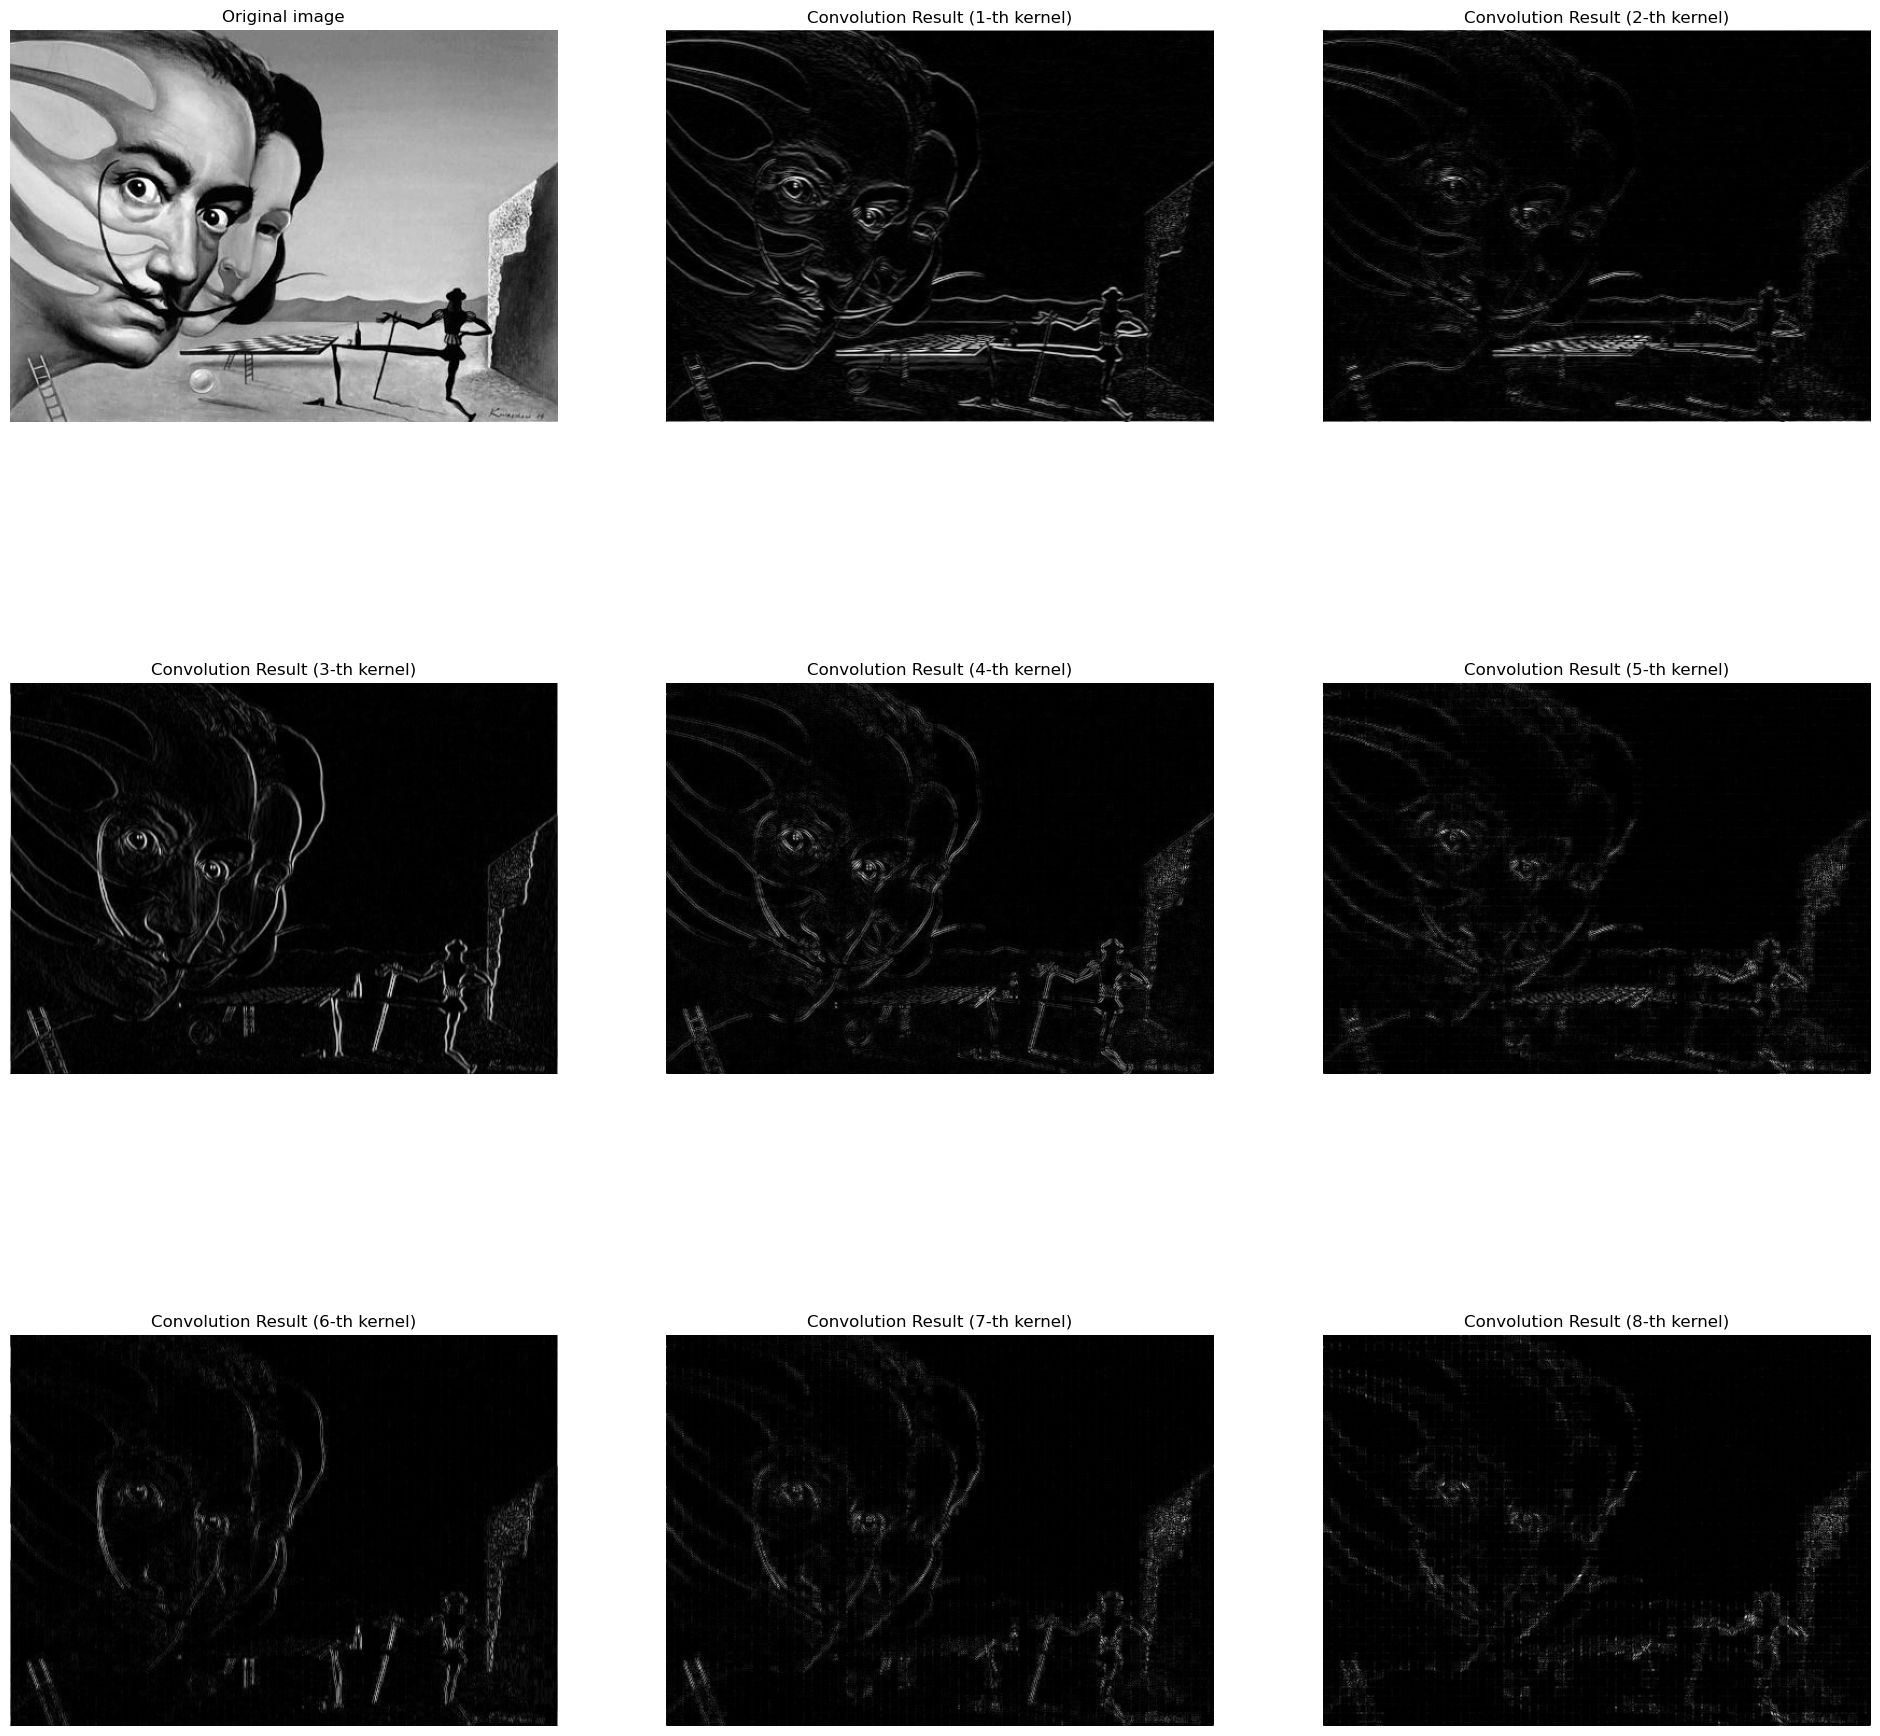

In [29]:
plot_kernels_and_img(np.array(img), np.abs(result))

(-0.5, 508.5, 363.5, -0.5)

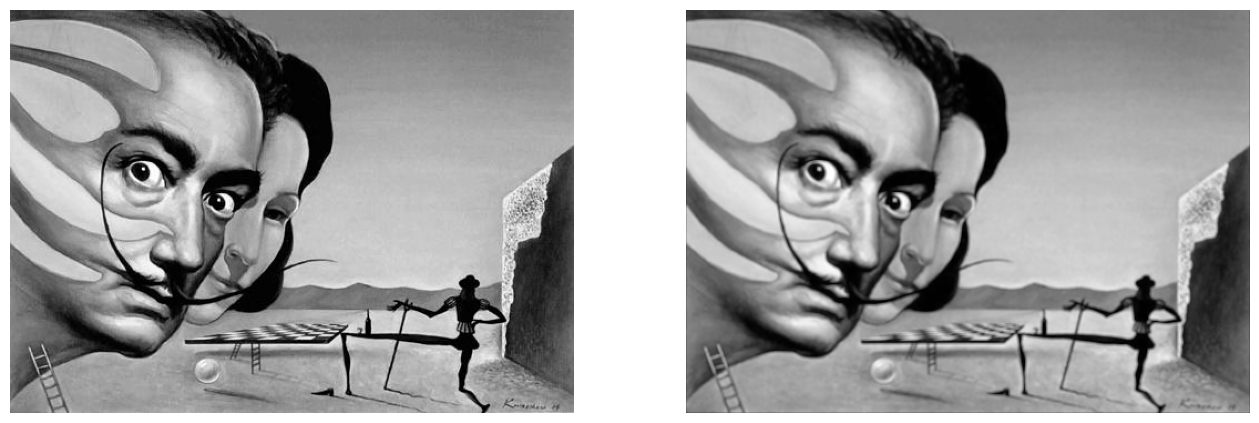

In [45]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(np.array(img),cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(np.sqrt(np.sum(result**2,axis=0)), cmap='gray')
plt.axis('off')

(-0.5, 508.5, 363.5, -0.5)

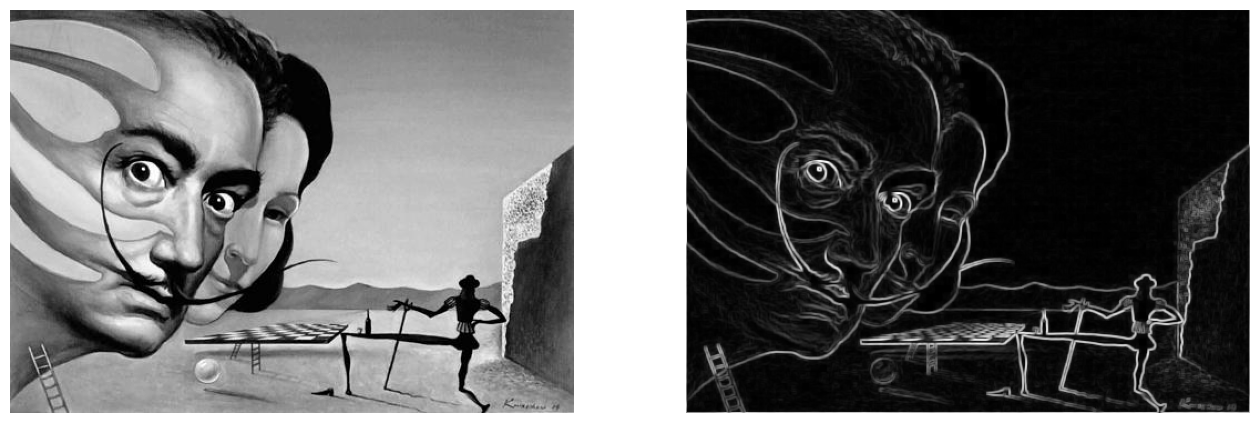

In [7]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(np.array(img),cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(np.sqrt(np.sum(result[1:,...]**2,axis=0)), cmap='gray')
plt.axis('off')